# Named Entity Recognition

Определение именованных сущностей -- выделение из текста имён собственных и классификация их по определённым классам, в случае использованной далее модели:
 - персон
 - организаций
 - локаций
 - прочих ИС

Возможное применение технологии -- экстракция навыков из резюме рекрутёрами.

## Data

In [1]:
import pandas as pd
import numpy as np
import pymongo
from pprint import pprint

from collections import defaultdict
import json

In [2]:
client = pymongo.MongoClient('localhost', 27017)
db = client["news"]
data = db["data"]

## Model

In [3]:
import flair, torch
from flair.models import SequenceTagger
from flair.tokenization import SegtokSentenceSplitter
from flair.data import Sentence

In [4]:
torch.cuda.is_available()

True

In [5]:
!nvidia-smi

Wed Feb 22 17:01:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8    N/A /  N/A |      6MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
flair.device = torch.device("cuda:0")

In [7]:
splitter = SegtokSentenceSplitter()
#tagger = SequenceTagger.load('ner')
tagger = SequenceTagger.load('ner-fast')

/home/scurrra/Programs/Anaconda/envs/nlp/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


2023-02-22 17:01:12,825 loading file /home/scurrra/.flair/models/ner-english-fast/4c58e7191ff952c030b82db25b3694b58800b0e722ff15427f527e1631ed6142.e13c7c4664ffe2bbfa8f1f5375bd0dced866b8c1dd7ff89a6d705518abf0a611
2023-02-22 17:01:14,933 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [8]:
stats = {
    "last_new_indx": -1,
    "PER":  defaultdict(list),
    "LOC":  defaultdict(list),
    "ORG":  defaultdict(list),
    "MISC": defaultdict(list)
}

In [18]:
def split_news(news: dict):
    splitted = splitter.split(news["content"])
    splitted.append(Sentence(news["title"]))
    if isinstance(news["description"], str):
        splitted.extend(
            splitter.split(news["description"])
        )
    return splitted

In [1]:
def ner_eval(stats: dict, news: dict):
    splitted = split_news(news)

    tagger.predict(splitted)

    buf_stats = {
        "PER":  defaultdict(int),
        "LOC":  defaultdict(int),
        "ORG":  defaultdict(int),
        "MISC": defaultdict(int)
    }     # костыль

    # число вхождений в текст
    for sentence in splitted:
        for entity in sentence.get_spans("ner"):
            #print(entity)
            buf_stats[entity.tag][entity.text] += 1 

    for key in buf_stats.keys():
        for entity in buf_stats[key].keys():
            stats[key][entity].append((news["index"], buf_stats[key][entity]))

In [6]:
ner_stats = db["ner_stats"]
# ner_stats.insert_one(stats)

ner_stats__sa_full = db["ner_stats__sa_full"]
# ner_stats__sa_full.insert_one({
#     "PER":  defaultdict(list),
#     "LOC":  defaultdict(list),
#     "ORG":  defaultdict(list),
#     "MISC": defaultdict(list)
# })

### Test on one of the news

In [11]:
stats = {
    "PER":  defaultdict(list),
    "LOC":  defaultdict(list),
    "ORG":  defaultdict(list),
    "MISC": defaultdict(list)
}

In [12]:
new_test = data.find_one({"index": 4712})
new_test;

In [13]:
test_splitted = splitter.split(new_test["content"])
test_splitted.append(Sentence(new_test["title"]))
if isinstance(new_test["description"], str):
    test_splitted.extend(
        splitter.split(new_test["description"])
    )

test_splitted

[Sentence: "( CNN ) Right now , there 's a shortage of truck drivers in the US and worldwide , exacerbated by the e-commerce boom brought on by the pandemic .",
 Sentence: "One solution to the problem is autonomous trucks , and several companies are in a race to be the first to launch one .",
 Sentence: "Among them is San Diego-based TuSimple.Founded in 2015 , TuSimple has completed about 2 million miles of road tests with its 70 prototype trucks across the US , China and Europe .",
 Sentence: "Although these are simply commercially available trucks retrofitted with its technology , TuSimple has deals in place with two of the world 's largest truck manufacturers -- Navistar in the US and Traton , Volkswagen 's trucking business , in Europe -- to design and build fully autonomous models , which it hopes to launch by 2024 .",
 Sentence: "Photos : The Yara Birkeland is what its builders call the world 's first zero-emission , autonomous cargo ship .",
 Sentence: "The ship is scheduled to 

In [14]:
tagger.predict(test_splitted)

In [15]:
test_splitted[0].get_spans("ner")[0].get_label()

'Span[15:16]: "US"'/'LOC' (0.999)

In [16]:
test_splitted[0].get_spans("ner")[0].text

'US'

In [17]:
test_splitted[0].get_spans("ner")[0].tag

'LOC'

In [18]:
test_splitted[0].get_spans("ner")[0].score

0.9989510774612427

In [19]:
INDX = 4712

In [20]:
buf_stats = {
    "PER":  defaultdict(list),
    "LOC":  defaultdict(list),
    "ORG":  defaultdict(list),
    "MISC": defaultdict(list)
}     # костыль

for sentence in test_splitted:
    for entity in sentence.get_spans("ner"):
        #print(entity)
        buf_stats[entity.tag][entity.text].append(1) 

for key in buf_stats.keys():
    for entity in buf_stats[key].keys():
        stats[key][entity].append((INDX, sum(buf_stats[key][entity])))
    print(key)
    pprint(stats[key])

stats

PER
defaultdict(<class 'list'>,
            {'Cheng Lu': [(4712, 1)],
             'Grayson Brulte': [(4712, 1)],
             'Lu': [(4712, 9)],
             'Steve Lee': [(4712, 1)],
             'Stretch': [(4712, 1)],
             'TuSimple': [(4712, 2)]})
LOC
defaultdict(<class 'list'>,
            {'Arizona': [(4712, 2)],
             'Aurora': [(4712, 1)],
             'Boston': [(4712, 1)],
             'China': [(4712, 5)],
             'Dallas': [(4712, 1)],
             'Denmark': [(4712, 1)],
             'Dubai': [(4712, 1)],
             'El Paso': [(4712, 1)],
             'Europe': [(4712, 3)],
             'Germany': [(4712, 1)],
             'London': [(4712, 1)],
             'Maglev': [(4712, 1)],
             'Netherlands': [(4712, 1)],
             'Nogales': [(4712, 1)],
             'Oklahoma City': [(4712, 1)],
             'Phoenix': [(4712, 1)],
             'Qingdao': [(4712, 1)],
             'Shandong Province': [(4712, 1)],
             'Sharjah': [(4712,

{'PER': defaultdict(list,
             {'Steve Lee': [(4712, 1)],
              'Cheng Lu': [(4712, 1)],
              'TuSimple': [(4712, 2)],
              'Lu': [(4712, 9)],
              'Stretch': [(4712, 1)],
              'Grayson Brulte': [(4712, 1)]}),
 'LOC': defaultdict(list,
             {'US': [(4712, 9)],
              'China': [(4712, 5)],
              'Europe': [(4712, 3)],
              'Maglev': [(4712, 1)],
              'Qingdao': [(4712, 1)],
              'Shandong Province': [(4712, 1)],
              'Netherlands': [(4712, 1)],
              'UAE': [(4712, 1)],
              'Sharjah': [(4712, 1)],
              'Dubai': [(4712, 1)],
              'Germany': [(4712, 1)],
              'Nogales': [(4712, 1)],
              'Arizona': [(4712, 2)],
              'Oklahoma City': [(4712, 1)],
              'Tucson': [(4712, 1)],
              'Dallas': [(4712, 1)],
              'TuSimple': [(4712, 2)],
              'Texas': [(4712, 1)],
              'Phoenix': [

## Evaluating

In [10]:
from tqdm import tqdm

### SA-Full dataset

In [26]:
sa_full_indx = sorted([_["index"] for _ in db["sa_full"].find()])

In [27]:
stats__sa_full = list(ner_stats__sa_full.find())[-1]

for key in ["PER", "LOC", "ORG", "MISC"]:
    stats__sa_full[key] = defaultdict(list, stats__sa_full[key])

{key: len(stats__sa_full[key]) for key in ["PER", "LOC", "ORG", "MISC"]}

{'PER': 2409, 'LOC': 630, 'ORG': 895, 'MISC': 1100}

In [28]:
samples = data.find({"index": {"$in": sa_full_indx}})

In [27]:
ner_samples_failed__sa_full = []
for new in tqdm(samples, total=len(sa_full_indx)):
    try:
        ner_eval(stats__sa_full, new)
    except:
        ner_samples_failed__sa_full.append(new["index"])
print(ner_samples_failed__sa_full)

100%|██████████| 97/97 [03:17<00:00,  2.03s/it]

[]


In [33]:
{key: len(stats__sa_full[key]) for key in ["PER", "LOC", "ORG", "MISC"]}

{'PER': 2409, 'LOC': 630, 'ORG': 895, 'MISC': 1100}

In [29]:
ner_stats__sa_full.update_one({"_id": stats__sa_full["_id"]}, {"$set": stats__sa_full})

### Full dataset

In [6]:
stats = list(ner_stats.find())[-1]

for key in ["PER", "LOC", "ORG", "MISC"]:
    stats[key] = defaultdict(list, stats[key])

{key: len(stats[key]) for key in ["PER", "LOC", "ORG", "MISC"]}

{'PER': 27780, 'LOC': 7065, 'ORG': 18536, 'MISC': 11428}

In [7]:
del stats["_id"]
stats_json = json.dumps(stats)

with open("colab_nbs/stats.json", "w") as stats_file:
    stats_file.write(stats_json)

In [5]:
N_SAMPLES = 1000

In [48]:
samples = data.find({"index": {"$gt": stats["last_new_indx"], "$lte": stats["last_new_indx"]+N_SAMPLES}})

In [49]:
ner_samples_failed = []
for new in tqdm(samples, total=N_SAMPLES):
    try:
        ner_eval(stats, new)
    except:
        ner_samples_failed.append(new["index"])
stats["last_new_indx"] += N_SAMPLES
print(ner_samples_failed)

100%|██████████| 1000/1000 [26:21<00:00,  1.58s/it]

[5295]


In [50]:
stats["last_new_indx"]

5999

In [51]:
{key: len(stats[key]) for key in ["PER", "LOC", "ORG", "MISC"]}

{'PER': 27780, 'LOC': 7065, 'ORG': 18536, 'MISC': 11428}

In [52]:
ner_stats.update_one({"_id": stats["_id"]}, {"$set": stats})

In [30]:
# ner_stats.remove({"_id": stats["_id"]})

### Computed in Google Colab

In [3]:
import json

In [4]:
with open("colab_nbs/stats.json", "r") as stats_file:
    stats_colab = json.load(stats_file)

{key: len(stats_colab[key]) for key in ["PER", "LOC", "ORG", "MISC"]}

{'PER': 185089, 'LOC': 52875, 'ORG': 108032, 'MISC': 88084}

In [9]:
stats = list(ner_stats.find())[-1]

{key: len(stats[key]) for key in ["PER", "LOC", "ORG", "MISC"]}
stats["_id"]

ObjectId('63ee6b49dc6dad6ddfaa79c1')

In [12]:
stats_colab["_id"] = stats["_id"]

# failed to write becaise of document size
# ner_stats.update_one({"_id": stats["_id"]}, {"$set": stats_colab})

## Analysis

In [62]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
from datetime import datetime

In [61]:
sa_indx = sorted([_["index"] for _ in db["sa_full"].find()])

stats__sa_full = list(ner_stats__sa_full.find())[-1]

for key in ["PER", "LOC", "ORG", "MISC"]:
    stats__sa_full[key] = defaultdict(list, stats__sa_full[key])

news = {
    news["index"]: news
    for news in data.find({"index": {"$in": sa_indx}})
}

st = stats__sa_full
{key: len(st[key]) for key in ["PER", "LOC", "ORG", "MISC"]}

In [63]:
stats__sa_f10 = stats_colab

for key in ["PER", "LOC", "ORG", "MISC"]:
    stats__sa_f10[key] = defaultdict(list, stats__sa_f10[key])

# sa_indx = sorted([_["index"] for _ in db["sa_first10"].find()])
# news = {
#     news["index"]: news
#     for news in data.find({"index": {"$in": sa_indx}})
# }
news = {
    news["index"]: news
    for news in data.find()
}

st = stats__sa_f10
{key: len(st[key]) for key in ["PER", "LOC", "ORG", "MISC"]}

{'PER': 185089, 'LOC': 52875, 'ORG': 108032, 'MISC': 88084}

In [81]:
type(news[0]["date"])

float

In [121]:
top = {
    "PER": sorted(st["PER"].items(), key=lambda ent: len(ent[1]), reverse=True)[:10],
    "ORG": sorted((_ for _ in st["ORG"].items() if not _[0].startswith("CNN")), key=lambda ent: len(ent[1]), reverse=True)[:10],
    "LOC": sorted(st["LOC"].items(), key=lambda ent: len(ent[1]), reverse=True)[:10],
}

{key: len(top[key]) for key in ["PER", "LOC", "ORG"]}

{'PER': 10, 'LOC': 10, 'ORG': 10}

### `PER`

In [35]:
def get_stats_from_dict(ent: tuple, st=0):
    return [_[st] for _ in ent[1]]

Для топ-10 самых популярных персон из вашего датасета составьте список статей, в которых они упоминались. Результаты можно вывести в виде json-файла (person → list of articles’ titles).

In [36]:
[_[0] for _ in top["PER"]]

['Donald Trump',
 'Trump',
 'Vladimir Putin',
 'Joe Biden',
 'Biden',
 'Putin',
 'God',
 'Barack Obama',
 'Novak Djokovic',
 'Roger Federer']

In [37]:
{
    person[0]: (len(get_stats_from_dict(person)), sum(get_stats_from_dict(person, 1)))
    for person in top["PER"]
}

{'Donald Trump': (3054, 5065),
 'Trump': (2862, 16205),
 'Vladimir Putin': (1837, 3123),
 'Joe Biden': (1766, 2688),
 'Biden': (1592, 8344),
 'Putin': (1559, 7629),
 'God': (1273, 2139),
 'Barack Obama': (1237, 1559),
 'Novak Djokovic': (1201, 2627),
 'Roger Federer': (1196, 2563)}

In [38]:
{
    person[0]: [
        news[news_id]["title"]
        for news_id in get_stats_from_dict(person)
    ]
    for person in top["PER"]
}

{'Donald Trump': ['Branson show flops on US screens',
  'IMF urges key G20 countries spend gr',
  'Strong US July jobs numbers a likely boost for Cli',
  'This could be my last fight in US if Trump becomes president says Amir K',
  'American Muslims remember Ali as hero for their fai',
  'US markets not fully buying Hillary wi',
  'Gold slips firm dollar US election concerns lifting demand',
  'Dollar jumps Clinton gets eleventh hour election b',
  'US stocks dip as election day voting kicks off',
  'Dollar steady ahead of US presidential electi',
  'Trumps surprise wins rattle world mar',
  'US stocks surge as voters head to',
  'Oil dips on rising crude inventories after Trumps shock victory',
  'US companies react cautiously to Trump victory',
  'Oil prices fall on persistent fuel supply overhang',
  'Asia shares win reprieve as bond rout pauses for',
  'Asian shares on the defensive as US yields dollar ri',
  'Wall Street ends at record highs dollar loses',
  'Companies leaving US 

Составьте графики упоминания топ-3 популярных персон за весь временной промежуток, который представлен в ваших данных.

In [94]:
PER_dates = {
    person[0]: np.array([
        news[news_id]["date"]
        for news_id in get_stats_from_dict(person) if not isinstance(news[news_id]["date"], float)
    ])
    for person in top["PER"][:5]
}

In [95]:
top["PER"][0][0]

'Donald Trump'

In [96]:
[_[0] for _ in top["PER"][:5]]

['Donald Trump', 'Trump', 'Vladimir Putin', 'Joe Biden', 'Biden']

In [97]:
# @interact(
#     person=widgets.Dropdown(option=[_[0] for _ in top["PER"][:3]], value=top["PER"][0][0], description="Person")
# )
# def density_plot(person: str):
#     print(PER_dates[person])

In [98]:
persons = list(PER_dates.keys())
persons

['Donald Trump', 'Trump', 'Vladimir Putin', 'Joe Biden', 'Biden']

In [101]:
persons[0].endswith(persons[1])

True

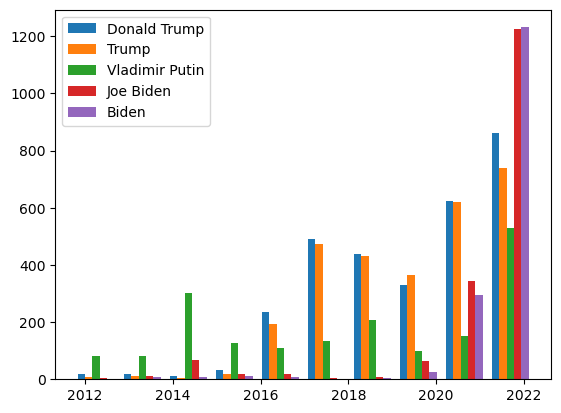

In [100]:
plt.hist(
    list(PER_dates.values())
);
plt.legend(persons);

### `ORG`

Какая организация оказалась самой “популярной” в ваших данных? Какие организации вошли в топ-5 по популярности? 

In [122]:
[_[0] for _ in top["ORG"]]

['Twitter',
 'European Union',
 'EU',
 'Manchester United',
 'Facebook',
 'Barcelona',
 'Chelsea',
 'Real Madrid',
 'Congress',
 'Liverpool']

Для топ-5 самых популярных организаций из вашего датасета составьте список статей, в которых они упоминались. Результаты можно вывести в виде json-файла (organization → list of articles’ titles).

In [123]:
{
    org[0]: [
        news[news_id]["title"]
        for news_id in get_stats_from_dict(org)
    ]
    for org in top["ORG"]
}

{'Twitter': ['nokia 215 dual sim launched in paki',
  'china stock market freezing up as sell off gathers',
  'Twitter stock plunges after revenue misses esti',
  'England cricketer Moeen Ali stopped at Birmingham airpor',
  'Chris Gayle and Ahmed Shehzad friendly banter on social medi',
  'West Indian cricket writercommentator Tony Cozier di',
  'Manchester City sign midfielder Guendogan from Dortmund',
  'Turkeys Tufan mocked over ill timed male grooming',
  'Waqar Younis missing wife romantic place Veni',
  'Zlatan Ibrahimovic to join Manchester United',
  'US sports stars call for end to gun vi',
  'Clashes outside Eiffel Tower fan zone during Euro fi',
  'Sales of Ivanka Trump apparel slumped at Nordstrom WSJ repor',
  'Social media platforms tread carefully when it comes to the Russian government - CNN',
  "Roman Abramovich: Death and destruction in Ukraine overshadows Russian oligarch's legacy at Chelsea - CNN",
  'Brittney Griner is reportedly well and has seen her Russian lega

### `LOC`

Найдите топ-10 локаций, упомянутых в новостях за тот период, что представлен в вашем датасете. Для топ-5 самых популярных из них составьте составьте список статей, в которых они упоминались. Результаты можно вывести в виде json-файла (location → list of articles’ titles).

In [124]:
[_[0] for _ in top["LOC"]]

['US',
 'London',
 'UK',
 'Europe',
 'United States',
 'England',
 'France',
 'Russia',
 'Germany',
 'Britain']

In [125]:
{
    loc[0]: [
        news[news_id]["title"]
        for news_id in get_stats_from_dict(loc)
    ]
    for loc in top["LOC"][:5]
}

{'US': ['Ad sales boost Time Warner profit',
  'Dollar gains on Greenspan speech',
  'Yukos unit buyer faces loan claim',
  'Pernod takeover talk lifts Domecq',
  'Jobs growth still slow in the US',
  'India calls for fair trade rules',
  'Court rejects $280bn tobacco case',
  "India's rupee hits five-year high",
  'US trade gap hits record in 2004',
  'Yukos loses US bankruptcy battle',
  'Safety alert as GM recalls cars',
  "Steel firm 'to cut' 45,000 jobs",
  'Strong demand triggers oil rally',
  "Soaring oil 'hits world economy'",
  "Ad firm WPP's profits surge 15%",
  'US gives foreign firms extra time',
  'Deutsche Telekom sees mobile gain',
  "Chinese wine tempts Italy's Illva",
  'Fed chief warning on US deficit',
  'US crude prices surge above $53',
  'Bad weather hits Nestle sales',
  'Fiat mulls Ferrari market listing',
  'Worldcom ex-boss launches defence',
  'Insurance bosses plead guilty',
  'Cars pull down US retail figures',
  'Lufthansa may sue over Bush visit',
  'EU 